# Исследование рынка компьютерных игр

### 1. Общая информация

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import math
from scipy import stats as st

data = pd.read_csv('/datasets/games.csv')
print(data.head())
print()
print(data.info())

                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11

Датасет имеет 16715 строк и 11 колонок с данными, содержащих информацию о названии, платформе, годе выпуска и продажах компьютерных игр по всему миру. Так же включает в себя оценку игры пользователями и критиками, и рейтинг от организации ESRB. На первый взгляд можно отметить наличие пропусков в столбцах Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating.

По столбцам Name, Year_of_Release, Genre удалим строки датасета, содержащие пропущенные значения этих столбцов. В столбцах Critic_Score, User_Score и Rating пропущенные значения заменим на NaN, так как других логичных способов замены оценки и рейтинга нет, причины данных пропусков установить трудно - может игра не имеет оценок, или количество оценок не достаточно для выведения средней, игра не имеет рейтинга или вовсе не продавалась. 

Что касаемо типов данных, то выбивается столбец с неверным типом данных Year_of_Release, который должен быть целочисленным, а значит int. Так же тип данных возможно необходимо изменить в Critic_Score, на первый взгляд столбец содержит только целочисленные значения.

### 2. Подготовка данных

Заменим названия столбцов, приведём их к нижнему регистру

In [75]:
data.columns = map(str.lower, data.columns)
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Обработаем пропуски. Так как в столбцах name, year_of_release, genre очень маленькое, относительно датасета, число данных, то мы в них удалим строки содержащие пропуски. в остальных столбуах critic_score, user_score, rating пропуски заменим на NaN, то есть оставим, по сути, без изменения, потому что менять пропуски на медианную или средние показатели не логично из-за того, что это оценки и рейтинг, независимые друг от друга.

In [76]:
data.dropna(subset = ['name','year_of_release','genre'], inplace = True)
data['critic_score'] = data['critic_score'].fillna(np.NaN)
data['user_score'] = data['user_score'].fillna(np.NaN)
data['rating'] = data['rating'].fillna(np.NaN)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Преобразуем данные в нужные типы. Заменили тип данных в столбце year_of_releasе на int из-за того, что он состоит из целочисленных значений. Тип данных в name, platform, genre, rating оставляем таким же - object, потому что данные столбцы содержат текст. Что касается столбцов с данными, которые содержат информацию о продажах, то оставим тип данных в них float, то есть число с запятой из-за того, что данные в них выражены в млн долларов, что может существенно исказить данные при округлении в меньшую или большую стороны. Изменение типа данных столбца user_score рассмотрим далее.

В столбце с пользовательским рейтингом обнаружили аббревиатуру 'tbd'. Tbd обозначает, что для выставления средней пользовательской оценки игры не хватило количество этих оценок в связи с тем, что игра либо не давно вышла, либо не популярна. В связи с эти заменим значения 'tbd' столбца user_score на NaN-значение, соответственно и поменяется тип данных на float, который нам подходит - нецелочисленные значения.

In [77]:
data = data.astype({"year_of_release":'int64'})
print(data['user_score'].value_counts())
data['user_score'] = pd.to_numeric(data['user_score'], errors ='coerce')
print(data['user_score'].value_counts())

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.3       2
1.5       2
0.9       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64
7.8    322
8.0    285
8.2    276
8.3    252
7.5    249
      ... 
9.6      2
0.6      2
1.9      2
9.7      1
0.0      1
Name: user_score, Length: 95, dtype: int64


Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [78]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52


### 3. Исследовательский анализ данных


Посмотрим сколько игр выпускалось в разные годы. Для анализа можно отбросить периоды времени, в которых игровая индустрия еще не была так развита и широкораспространена. Этот период с начала 80-х до середины 90-х годов. Далее исходя из таблицы наблюдаем рост индустрии.

In [79]:
year_count_pivot = data.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
year_count_pivot

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


Посмотрим, как менялись продажи по платформам. Посчитаем платформы с наибольшими суммарными продажами (у нас это PS2, X360, PS3, Wii, DS) за весь период. Построим график распределения по годам совокупных продаж этих платформ. Жизненный цикл платформы можно определить как 5-7 лет, меняется версия платформы или её заменяет совершенно новая. Что видно исходя из графика продаж топовых платформ.

          total_sales
platform             
PS2           1233.56
X360           961.24
PS3            931.34
Wii            891.18
DS             802.78


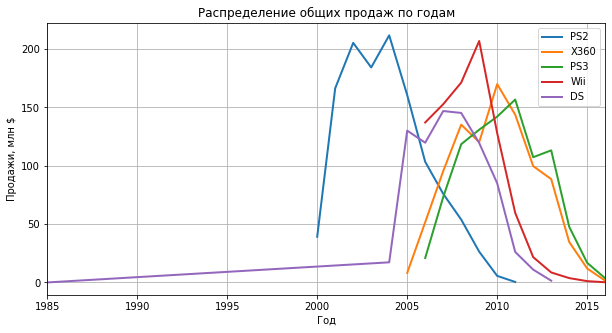

In [80]:
platform_sales_pivot = data.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values('total_sales', ascending = False)
print(platform_sales_pivot.head(5))

platform_year_sales_pivot = data.pivot_table(index = ['year_of_release', 'platform'], values = 'total_sales', aggfunc = 'sum')
platform_year_sales_pivot.reset_index(inplace = True)
platform_year_sales_pivot = platform_year_sales_pivot.loc[platform_year_sales_pivot['platform'].isin(['PS2','X360','PS3','Wii','DS'])]

platforms = ['PS2','X360','PS3','Wii','DS']
for i in platforms:
    d = platform_year_sales_pivot.query('platform == @i')
    ax = plt.gca()
    d.plot(x='year_of_release', y= 'total_sales', label = 'platforms', grid=True, linewidth = 2, figsize=(10, 5), ax=ax)
    ax.legend(['PS2','X360','PS3','Wii','DS'])
    
plt.title('Распределение общих продаж по годам')
plt.xlabel('Год')
plt.ylabel('Продажи, млн $')
plt.show()

Возьмем данные за актуальный период - последние 5 лет, значит с 2012 года. Эти данные помогут построить прогноз на 2017 год. Данные за более ранние периоды в работе учитывать не будем. 

['3DS' 'DS' 'PC' 'PS3' 'PSP' 'PSV' 'Wii' 'WiiU' 'X360' 'PS4' 'XOne']


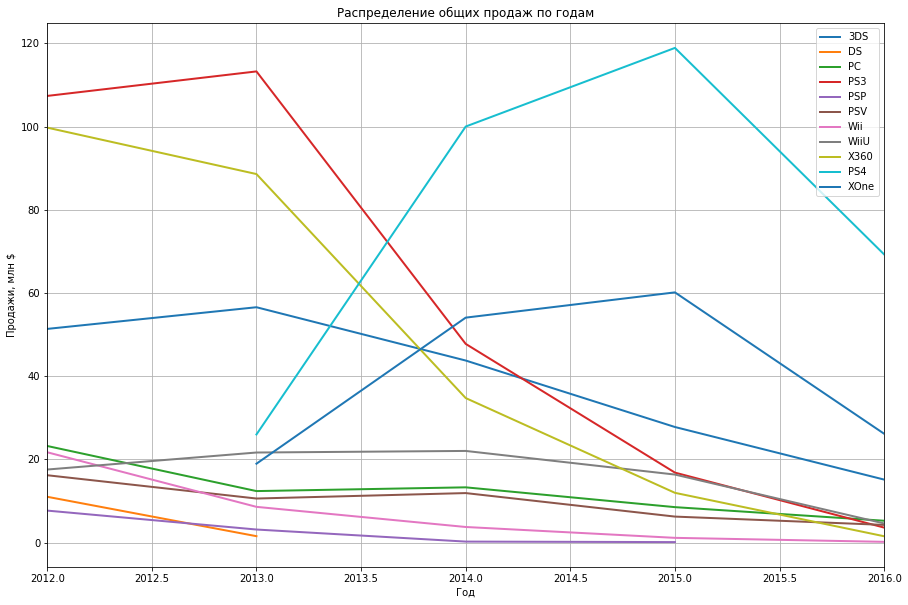

In [82]:
a_platform_sales_pivot = data.pivot_table(index = ['year_of_release', 'platform'], values = 'total_sales', aggfunc = 'sum')
#.sort_values('total_sales', ascending = False)
a_platform_sales_pivot.reset_index(inplace = True)
a_platform_sales_pivot = a_platform_sales_pivot.loc[a_platform_sales_pivot['year_of_release'].isin(['2012','2013','2014','2015','2016'])]
a_platform_sales_pivot.reset_index(inplace = True)
del a_platform_sales_pivot['index']

print(a_platform_sales_pivot['platform'].unique())

platforms = ['3DS', 'DS', 'PC', 'PS3', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'PS4', 'XOne']
for i in platforms:
    d = a_platform_sales_pivot.query('platform == @i')
    ax = plt.gca()
    d.plot(x='year_of_release', y= 'total_sales', label = 'platforms', grid=True, linewidth = 2, figsize=(15, 10), ax=ax)
    ax.legend(['3DS', 'DS', 'PC', 'PS3', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'PS4', 'XOne'])
    
plt.title('Распределение общих продаж по годам')
plt.xlabel('Год')
plt.ylabel('Продажи, млн $')
plt.show()

Если брать в расчет, что за 2016 год представлены не полные данные, то лидерами продаж остаются следующие платформы - PS4, 3DS и Xone. Но и они имеют нисходящий тренд, скорее всего, опять же из-за того, что не представлены полные данные за 2016 год. Остальные платформы тоже не показывают тренда к росту и в основном сходятся на продажах в 10 млн долларов в год. Близкие  к нулю по продажам платформы X360 и Wii. Прекратились продажи за последние 5 лет у таких платформ как DS и PSP.

Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам.

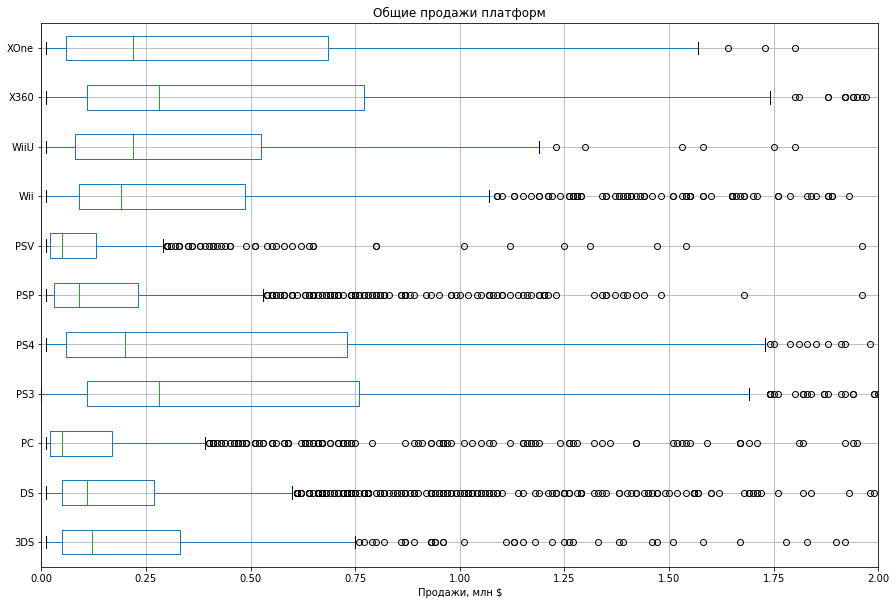

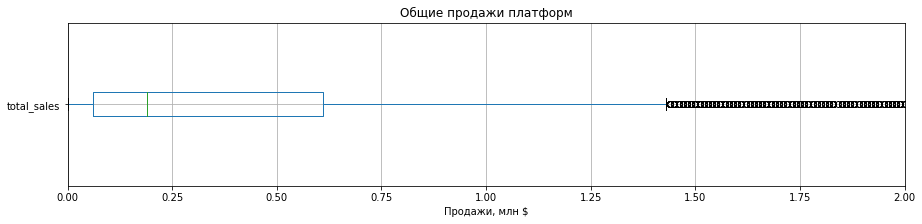

In [83]:
plt.figure(figsize=(15, 10))
plt.xlim(0, 2)
data_platforms = data.loc[data['platform'].isin(['3DS', 'DS', 'PC', 'PS3', 'PSP', 'PSV', 'Wii', 'WiiU', 'X360', 'PS4', 'XOne'])]
data_sales_per_platform = data_platforms.pivot_table(index = 'name', columns = 'platform', values = 'total_sales', aggfunc = 'sum')
data_sales_per_platform.boxplot(vert=False)
plt.title('Общие продажи платформ')
plt.xlabel('Продажи, млн $')

plt.figure(figsize=(15, 3))
plt.xlim(0, 2)
data_sales_total = data.pivot_table(index = 'name', values = 'total_sales', aggfunc = 'sum')
data_sales_total.boxplot(vert=False)
plt.title('Общие продажи платформ')
plt.xlabel('Продажи, млн $')
#plt.ylabel('Total')
plt.show()

Анализ графика "ящик с усами" говорит, о том, что глобальные продажи по платформам различаются. Некоторые платформы (PSV, PC) занимают небольшой объем продаж в структуре общих продаж. Средние значения по каждой платформе находятся в примерно одинаковом диапозоне, в отличие от размаха . Лидерами можно считать PS3 и X360, XOne и PS4. Размах данных по общим продажам соотносится с продажами в отдельности по платфоромам - среднее сначение так же близко к значению среднего по платформам в отдельности.

Построим график "ящик с усами" для 10 популярных фильмов и сравним с данными полученными по платформам.

['Wii Sports' 'Grand Theft Auto V' 'Super Mario Bros.' 'Tetris'
 'Mario Kart Wii' 'Wii Sports Resort' 'Pokemon Red/Pokemon Blue'
 'Call of Duty: Modern Warfare 3' 'New Super Mario Bros.'
 'Call of Duty: Black Ops II']


Text(0.5, 0, 'Продажи, млн $')

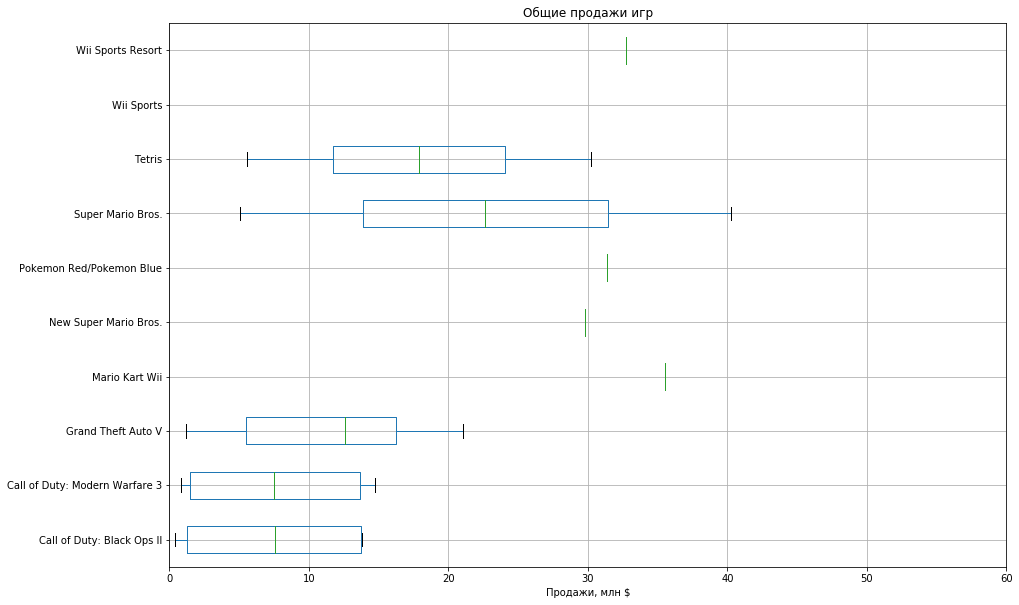

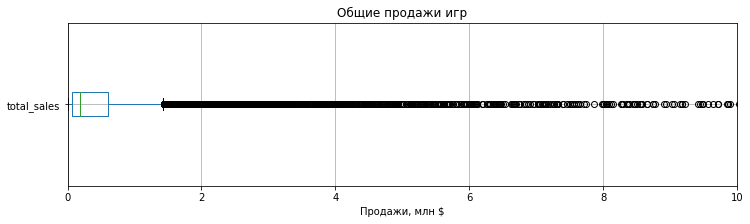

In [84]:
name_total_sales_pivot = data.pivot_table(index = 'name', values = 'total_sales', aggfunc = 'sum')
name_total_sales_pivot.reset_index(inplace = True)
name_total_sales_pivot = name_total_sales_pivot.sort_values('total_sales', ascending=False).head(10)
print(name_total_sales_pivot['name'].unique())
names = ['Wii Sports', 'Grand Theft Auto V', 'Super Mario Bros.', 'Tetris', 'Mario Kart Wii', 'Wii Sports Resort', 'Pokemon Red/Pokemon Blue', 'Call of Duty: Modern Warfare 3', 'New Super Mario Bros.', 'Call of Duty: Black Ops II']

plt.figure(figsize=(15, 10))
plt.xlim(0, 60)
data_names = data.loc[data['name'].isin(['Wii Sports', 'Grand Theft Auto V', 'Super Mario Bros.', 'Tetris', 'Mario Kart Wii', 'Wii Sports Resort', 'Pokemon Red/Pokemon Blue', 'Call of Duty: Modern Warfare 3', 'New Super Mario Bros.', 'Call of Duty: Black Ops II'])]
data_sales_per_name = data_names.pivot_table(index = 'platform', columns = 'name', values = 'total_sales', aggfunc = 'sum')
data_sales_per_name.reset_index(inplace = True)
data_sales_per_name.boxplot(vert=False)
plt.title('Общие продажи игр')
plt.xlabel('Продажи, млн $')

plt.figure(figsize=(12, 3))
plt.xlim(0, 10)
data_sales_nametotal = data.pivot_table(index = 'name', values = 'total_sales', aggfunc = 'sum')
data_sales_nametotal.boxplot(vert=False)
plt.title('Общие продажи игр')
plt.xlabel('Продажи, млн $')

Анализ графика "ящик с усами" показал, что глобальные продажи по играм существенно различаются в зависимости от игры. Некоторые игры "взлетают" и показывают хороший объем продаж в структуре общих продаж. Средние значения по каждой игре находятся на разном уровне. Размах "усов" по общим продажам значительно меньше продаж каждой игры в отдельности Среднее значение так же разнится. 

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграммы рассеяния и посчитаем корреляцию между отзывами и продажами.

Корреляция между оценкой критиков и общими продажами:  0.4327589578997135
Корреляция между оценкой пользователей и общими продажами:  0.12841562938563028


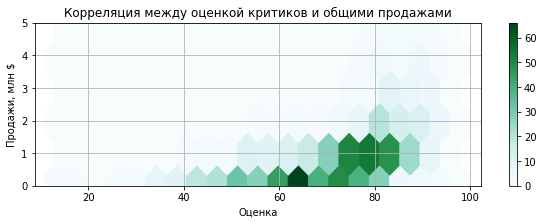

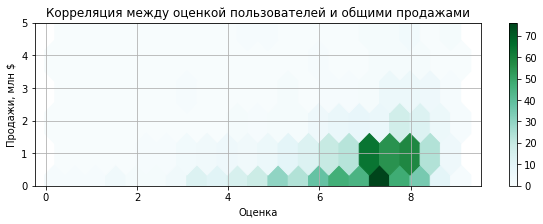

In [85]:
data_ps3 = data.query('platform == "PS3"')
print('Корреляция между оценкой критиков и общими продажами: ', data_ps3['critic_score'].corr(data_ps3['total_sales']))
print('Корреляция между оценкой пользователей и общими продажами: ',data_ps3['user_score'].corr(data_ps3['total_sales']))

data_ps3.plot(x='critic_score', y='total_sales', kind='hexbin', gridsize=20, figsize=(10, 3), sharex=False, grid=True)
plt.ylim(0, 5)
plt.title('Корреляция между оценкой критиков и общими продажами')
plt.xlabel('Оценка')
plt.ylabel('Продажи, млн $')
plt.show()
data_ps3.plot(x='user_score', y='total_sales', kind='hexbin', gridsize=20, figsize=(10, 3), sharex=False, grid=True)
plt.ylim(0, 5)
plt.title('Корреляция между оценкой пользователей и общими продажами')
plt.xlabel('Оценка')
plt.ylabel('Продажи, млн $')
plt.show()

Корреляция между оценкой критиков и общими продажами - средняя, то есть имеется прямая зависимость продаж от оценок, так и оценок от продаж. Чем лучше игра по мнению критиков, тем лучше она продается. Значение корреляции равно 0,43, что еще далеко до 1, это говорит, что эта связь могла бы быть сильнее. Что касается оценки пользователей, то здесь так же наблюдается зависимость, но она очень слабая. Исходя из этого, можно отметить оценка игры критиками важнее и больше влияет на продажи, чем оценка самих пользователей.

Посмотрим на общее распределение игр по жанрам.

In [86]:
data_sum_rev = data.pivot_table(index = ['genre'], values = 'total_sales', aggfunc = ['count','sum','mean'])
data_sum_rev

,count,sum,mean
,total_sales,total_sales,total_sales
genre,,,
Action,3307,1716.52,0.519057
Adventure,1293,233.33,0.180456
Fighting,837,442.66,0.528865
Misc,1721,790.29,0.459204
Platform,878,825.55,0.940262
Puzzle,569,239.89,0.421599
Racing,1226,723.49,0.590122
Role-Playing,1481,931.08,0.628683


Самыми прибыльными жанрами из расчета по совокупным продажам являются Action, Sports и Shooter. Что не вызывает удивления - универсальные жанры для всех регионов. Имеются так же жанры с очень низкими продажами - это Strategy и Adventure. Но стоит отметить, что в среднем на игру высокие продажи имеют игры-платформеры (Platform) и "стрелялки" (Shooter). Самый низкий показатель продаж в среднем на одну игру жанра приключенченских игр (Adventure).

### 4.  Портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [87]:
data_na_p = data.pivot_table(index = ['platform'], values = 'na_sales', aggfunc = ['count', 'sum'])
data_na_p.reset_index(inplace=True)
data_na_p.rename(columns={'na_sales': ''}, inplace=True)
data_na_p.sort_values('sum', ascending = False).head(5)

,platform,count,sum
,,,
28,X360,1232,595.74
16,PS2,2127,572.92
26,Wii,1286,486.87
17,PS3,1306,390.13
4,DS,2121,380.31


In [88]:
data_na_g = data.pivot_table(index = ['genre'], values = 'na_sales', aggfunc = ['count', 'sum'])
data_na_g.reset_index(inplace=True)
data_na_g.rename(columns={'na_sales': ''}, inplace=True)
data_na_g.sort_values('sum', ascending = False).head(5)

,genre,count,sum
,,,
0,Action,3307,863.17
10,Sports,2306,671.20
8,Shooter,1296,584.83
4,Platform,878,444.44
3,Misc,1721,399.57


Для Северной Америки популярны таких игровые платформы как X360, PS2, Wii, Ps3, DS с объемом продаж от 400 до 600 милн долларов на каждую платформу. Популярными жанрами являются Action, Sports, Shooter, Platform и Misc. У Action достаточно высокий показатель продаж на жанр, отрывающийся от других - 863 млн. долларов.

In [89]:
data_eu_p = data.pivot_table(index = ['platform'], values = 'eu_sales', aggfunc = ['count', 'sum'])
data_eu_p.reset_index(inplace=True)
data_eu_p.rename(columns={'eu_sales': ''}, inplace=True)
data_eu_p.sort_values('sum', ascending = False).head(5)

,platform,count,sum
,,,
16,PS2,2127,332.63
17,PS3,1306,327.21
28,X360,1232,268.32
26,Wii,1286,258.32
15,PS,1190,212.39


In [90]:
data_eu_g = data.pivot_table(index = ['genre'], values = 'eu_sales', aggfunc = ['count', 'sum'])
data_eu_g.reset_index(inplace=True)
data_eu_g.rename(columns={'eu_sales': ''}, inplace=True)
data_eu_g.sort_values('sum', ascending = False).head(5)

,genre,count,sum
,,,
0,Action,3307,510.99
10,Sports,2306,371.33
8,Shooter,1296,314.52
6,Racing,1226,234.49
3,Misc,1721,210.60


Для Европы популярны таких игровые платформы как X360, PS2, Wii, Ps3, PS. Лидеры имеют объем продаж более 300 млн. долларов. Популярные игровые платформы мало отличаются от североамерикансих. Популярными жанрами являются Action, Sports, Shooter, Racing и Misc. У Action достаточно высокий показатель продаж на жанр, отрывающийся от других - 511 млн. долларов.

In [91]:
data_jp_p = data.pivot_table(index = ['platform'], values = 'jp_sales', aggfunc = ['count', 'sum'])
data_jp_p.reset_index(inplace=True)
data_jp_p.rename(columns={'jp_sales': ''}, inplace=True)
data_jp_p.sort_values('sum', ascending = False).head(5)

,platform,count,sum
,,,
4,DS,2121,175.02
15,PS,1190,139.78
16,PS2,2127,137.54
23,SNES,239,116.55
2,3DS,512,100.62


In [92]:
data_jp_g = data.pivot_table(index = ['genre'], values = 'jp_sales', aggfunc = ['count', 'sum'])
data_jp_g.reset_index(inplace=True)
data_jp_g.rename(columns={'jp_sales': ''}, inplace=True)
data_jp_g.sort_values('sum', ascending = False).head(5)

,genre,count,sum
,,,
7,Role-Playing,1481,353.39
0,Action,3307,160.14
10,Sports,2306,134.93
4,Platform,878,130.71
3,Misc,1721,107.02


Для Японии популярны таких игровые платформы как PS, DS, PS2, SNES, 3DS. Лидер - DS с объемом продаж 175 млн. долларов. Популярные игровые платформы значительно отличаются от североамерикансих и европейских. Популярными жанрами являются Role-Playing, Action, Sports, Platform и Misc. У Role-Playing достаточно высокий показатель продаж на жанр, отрывающийся от других - 353 млн. долларов. Этот жанр не встречается в лидерах у Северной Америки и в Европе. Ролевые игры наимболее популярны в Японии.

Проанализируем влияет ли рейтинг ESRB на продажи в отдельном регионе, для этого построим график "ящик с усами" по каждому региону.

In [93]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

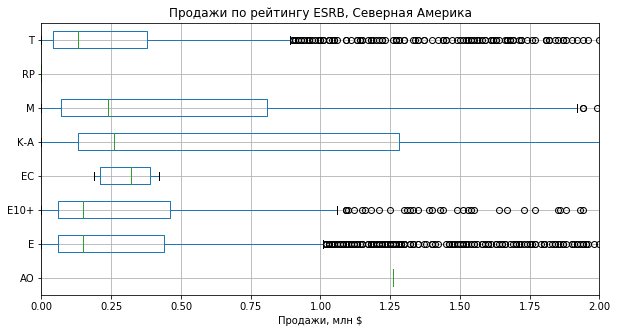

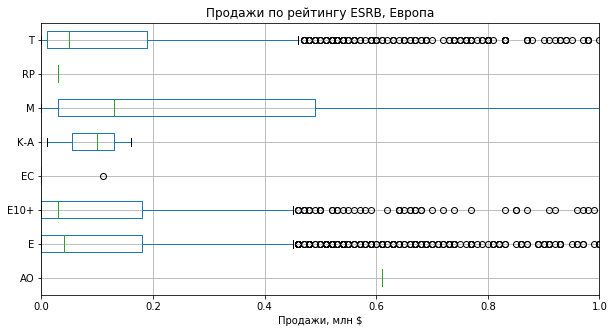

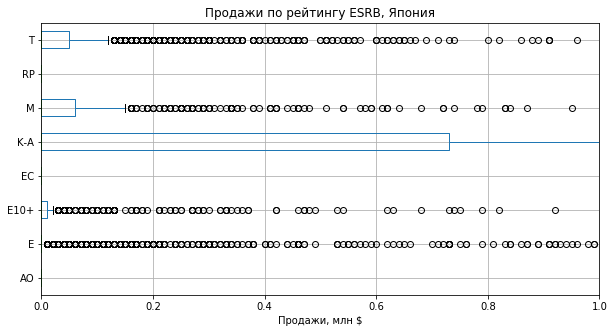

In [94]:
data_rating = data.loc[data['rating'].isin(['E', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'])]

plt.figure(figsize=(10, 5))
plt.xlim(0, 2)
data_sales_per_rating = data_rating.pivot_table(index = 'name', columns = 'rating', values = 'na_sales', aggfunc = 'sum')
data_sales_per_rating.reset_index(inplace = True)
data_sales_per_rating.boxplot(vert=False)
plt.title('Продажи по рейтингу ESRB, Северная Америка')
plt.xlabel('Продажи, млн $')
plt.show()


plt.figure(figsize=(10, 5))
plt.xlim(0, 1)
data_sales_per_rating = data_rating.pivot_table(index = 'name', columns = 'rating', values = 'eu_sales', aggfunc = 'sum')
data_sales_per_rating.reset_index(inplace = True)
data_sales_per_rating.boxplot(vert=False)
plt.title('Продажи по рейтингу ESRB, Европа')
plt.xlabel('Продажи, млн $')
plt.show()

plt.figure(figsize=(10, 5))
plt.xlim(0, 1)
data_sales_per_rating = data_rating.pivot_table(index = 'name', columns = 'rating', values = 'jp_sales', aggfunc = 'sum')
data_sales_per_rating.reset_index(inplace = True)
data_sales_per_rating.boxplot(vert=False)
plt.title('Продажи по рейтингу ESRB, Япония')
plt.xlabel('Продажи, млн $')
plt.show()

Entertainment Software Rating Board (ESRB) - организация определяющая рейтинг компьютерных видеоигр. Она присваивает возрастную категорию, для которой эта игра предназначена. Например:
- «EC» («Early childhood») — «Для детей младшего возраста»
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам»
- «M» («Mature») — «Для взрослых»
- «AO» («Adults Only 18+») — «Только для взрослых»
- «RP» («Rating Pending») — «Рейтинг ожидается»

В зависимости от рейтинга зависит и количество потребителей, для которых игра предназначена. Различаются так же продажи в зависимости от региона. Для рейтинга К-А характерен максимальный объем продаж в Северной Америке и в Японии, это развивающие игры для детей старше 6-ти лет.  В Европейской чаcти и для Северной Америки популярен M-рейтинг, то есть игры для взрослых. Среднее значение продаж игр по рейтингу различается. Связваем с тем, что для Американского пользователя понятен рейтинг игры, так как он выставлен, для Японии достаточно мало данных для анализа попрулярности того или иного рейтинга.

###  5. Проверка гипотез

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные.



Для того, чтобы понять различаются ли средние пользовательские рейтинги для платформ Xbox One и PC, сформулируем гипотизу по критерию сравнения средних двух генеральных совокупностей так как мы имеем две совокупности. у которых нужно сравнить среднее значение (в нашем случае - пользовательский рейтинг).

Нулевая гипотеза будет звучать так: средние пользовательские рейтинги платформ Xbox One и PC равны. Тогда альтернативная будет звучать следующим образом: средние пользовательские рейтинги платформ Xbox One и PC не равны.

In [95]:
sample_1 = data[data.platform == 'XOne'].groupby(['genre'])["user_score"].mean()
sample_2 = data[data.platform == 'PC'].groupby(['genre'])["user_score"].mean()

#print(sample_1.mean())
#print(sample_2.mean())

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги платформ Xbox One и PC различаются")
else:
    print("Средние пользовательские рейтинги платформ Xbox One и PC одинаковые")

p-значение: 0.189761350864604
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые


Мы не отвергаем нулевую гипотезу "Средние пользовательские рейтинги платформ Xbox One и PC равны.".

Для того, чтобы понять различаются ли средние пользовательские рейтинги жанров Action и Sports, сформулируем гипотизу по критерию сравнения средних двух генеральных совокупностей так как мы имеем две совокупности. у которых нужно сравнить среднее значение (в нашем случае - пользовательский рейтинг).

Нулевая гипотеза будет звучать так: средние пользовательские рейтинги жанров Action и Sports равны. Тогда альтернативная будет звучать следующим образом: средние пользовательские рейтинги жанров Action и Sports разные.

In [96]:
sample_1 = data[data.genre == 'Action'].pivot_table(index = 'total_sales', values = 'user_score', aggfunc = 'mean')
sample_2 = data[data.genre == 'Sports'].pivot_table(index = 'total_sales', values = 'user_score', aggfunc = 'mean')

#print(sample_1.mean())
#print(sample_2.mean())

alpha = .05

results = st.ttest_ind(
    sample_1, 
    sample_2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Средние пользовательские рейтинги жанров Action и Sports разные")
else:
    print("Средние пользовательские рейтинги жанров Action и Sports одинаковые")

p-значение: [1.43188908e-06]
Средние пользовательские рейтинги жанров Action и Sports разные


Мы отвергаем нулевую гипотезу "Средние пользовательские рейтинги жанров Action и Sports равны.".

### 6. Общий вывод

В данном проекте проанализированы продажи компьютерных игр по всему миру интрнет-магазина "Стримчик". В ходе исследования приведены данные к необходимым типам, удалены пропущенные значения, исправлены общие ошибки в данных. Проведены исследовательский анализ данных, составлен портрет пользователя каждого региона, проверены гипотезы.

Проанализировали количество выпускаемых игр в год, определили, что для анализа необходима рассматривать тенденции за последние 5 лет, это значение примерно соотносится с циклом жизни платформы - появляется новая версия или платформа. Если брать в расчет, что за 2016 год представлены не полные данные, то лидерами продаж остаются следующие платформы - PS4, 3DS и Xone. Но и они имеют нисходящий тренд, скорее всего, опять же из-за того, что не представлены полные данные за 2016 год. Но, при выборе потенциальной останавливаемся на них. Анализ графиков "ящик с усами" показал, что не всегда только платформа является мерилом успешности игры, не маловажен и само название, жанр игры и оценка критиков/пользователей.

Самыми прибыльными жанрами из расчета по совокупным продажам являются Action, Sports и Shooter. Что не вызывает удивления - универсальные жанры для всех регионов. Имеются так же жанры с очень низкими продажами - это Strategy и Adventure. Но стоит отметить, что в среднем на игру высокие продажи имеют игры-платформеры (Platform) и "стрелялки" (Shooter). Самый низкий показатель продаж в среднем на одну игру жанра приключенченских игр (Adventure).

Для выбора потенциально популярного продукта необходимо так же опираться на предпочтения региона, в котором будет реализовываться игра в большей степени, например для Северной Америки и европейской части популярны тройка жанров Action, Sports, Shooter, тогда как в Японии помимио этих большое место занимает жанр ролевой игры - Role-Playing. То же самое относится  и к выбору платформы игры.

Наиболее подходящим рейтингом для потенциального продукта будет K-A (развивающие игры для детей старше 6 лет) и М (для взрослых). Показатели продаж и проникновение по ним значительно выше, чем по другим рейтингам ограничения возраста.

Осуществили проверку двух гипотез: средние пользовательские рейтинги платформ Xbox One и PC одинаковые и средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные. Обе они подтвердились, что дает основание полагать, что к выбору жанра игры нужно подходить тщательнее, чем к выбору платформы игры.